In [1]:
import os
import sys
code_dir = '/afs/inf.ed.ac.uk/user/s17/s1771906/masters-project/ben-rhodes-masters-project/proposal/code'
code_dir_2 = '/home/ben/ben-rhodes-masters-project/proposal/code'
code_dir_3 = '/afs/inf.ed.ac.uk/user/s17/s1771906/masters-project/ben-rhodes-masters-project/proposal/code/neural_network'
code_dirs = [code_dir, code_dir_2, code_dir_3]
for code_dir in code_dirs:
    if code_dir not in sys.path:
        sys.path.append(code_dir)

In [2]:
import numpy as np

# my code
from distribution import MissingDataProductOfTruncNormsPosterior, MissingDataProductOfTruncNormNoise
from fully_observed_models import MixtureOfTwoGaussians
from latent_variable_model import MissingDataUnnormalisedTruncNorm
from nce_optimiser import NCEOptimiser
from utils import *
from vnce_optimiser import VemOptimiser, SgdEmStep, MonteCarloVnceLoss

from matplotlib import pyplot as plt
from matplotlib import rc
from numpy import random as rnd
from scipy.optimize import newton_krylov
from scipy.stats import norm, multivariate_normal
from sklearn.neighbors import KernelDensity as kd

%matplotlib inline
rc('lines', linewidth=1)
rc('font', size=10)
rc('legend', fontsize=10)

In [3]:
noise_mean = np.array([3, 3], dtype=float)
noise_chol = np.array([3, 3], dtype=float)

scaling_param = np.array([0], dtype=float)
model_mean = np.array([3, 3], dtype=float)
model_chol = np.diag(np.array([3., 3.]))

In [4]:
noise = MissingDataProductOfTruncNormNoise(noise_mean, noise_chol)
model = MissingDataUnnormalisedTruncNorm(scaling_param, model_mean, model_chol)

In [5]:
noise_samples = noise.sample(100000)
model_samples = model.sample(100000)

sampling from the model...
total num samples from model accepted: 100000
finished sampling!


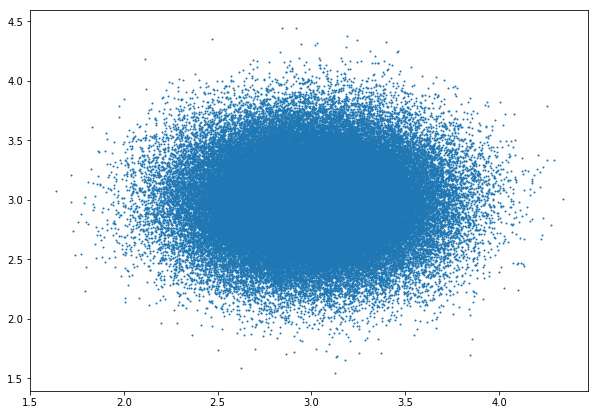

In [6]:
fig = plt.figure(figsize=(10, 7))
plt.scatter(noise_samples[:, 0], noise_samples[:, 1], s=1)

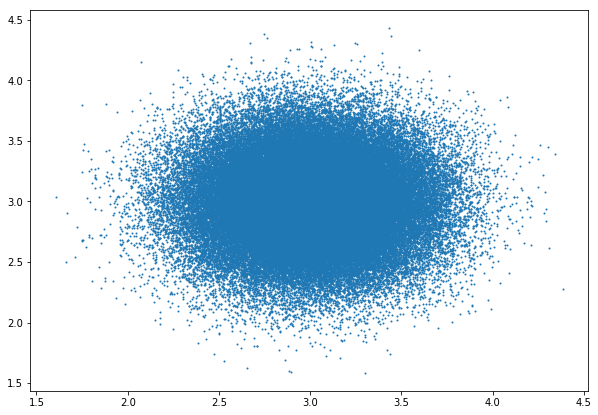

In [7]:
fig = plt.figure(figsize=(10, 7))
plt.scatter(model_samples[:, 0], model_samples[:, 1], s=1)

In [8]:
np.mean(np.log(model(noise_samples, np.zeros((1, ) + noise_samples.shape))))

-0.6356111475567979

In [9]:
np.mean(np.log(noise(noise_samples)))

[[3. 3.]
 [3. 3.]
 [3. 3.]
 ...
 [3. 3.]
 [3. 3.]
 [3. 3.]] [[3. 3.]
 [3. 3.]
 [3. 3.]
 ...
 [3. 3.]
 [3. 3.]
 [3. 3.]]


1.561613429779422

In [10]:
model(model_mean, np.zeros((1, ) + model_mean.shape))

array([1.43239449])

In [11]:
noise(model_mean)

[3. 3.] [3. 3.]


12.891550390443529

In [12]:
9 / (2 * np.pi)

1.432394487827058

In [13]:
multivariate_normal.pdf(model_mean, model_mean, 1/9)

1.4323944878270585

In [14]:
model.theta

array([0.        , 3.        , 3.        , 1.09861229, 0.        ,
       1.09861229])

In [15]:
noise.alpha

array([3.        , 3.        , 1.09861229, 1.09861229])